In [1]:
!pip -q install librosa umap-learn scikit-learn tqdm

In [2]:
import os, random, math
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

import librosa

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

import umap
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF:", tf.__version__)

TF: 2.19.0


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import kagglehub
kagglehub.dataset_download("thisisjibon/banglabeats3sec")

Using Colab cache for faster access to the 'banglabeats3sec' dataset.


'/kaggle/input/banglabeats3sec'

In [8]:
# === CHANGE THIS ===
DATA_CSV = "/content/drive/MyDrive/hybrid_dataset/hybrid_en_bn_3sec_30000_manifest.csv"

# Output folder
OUT_DIR = Path("/content/drive/MyDrive/hard_task_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA_CSV)
print("Rows:", len(df))
print(df.columns)

# Minimal cleaning
df["clip_path"] = df["clip_path"].astype(str)
df["language"] = df["language"].astype(str).str.lower()
df["lyrics_text"] = df["lyrics_text"].fillna("").astype(str)
df["genres"] = df["genres"].fillna("unknown").astype(str).str.lower()

# Keep only existing files
exists_mask = df["clip_path"].apply(lambda p: os.path.exists(p))
df = df[exists_mask].reset_index(drop=True)
print("After file-exists filter:", len(df))

Rows: 30000
Index(['song_id', 'clip_idx', 'abs_t0', 'abs_t1', 'rel_t0', 'rel_t1',
       'clip_path', 'language', 'source_dataset', 'genres', 'lyrics_text',
       'lyrics_len', 'clip_uid', 'language_id', 'has_lyrics', 'word_count',
       'char_count'],
      dtype='object')
After file-exists filter: 30000


In [55]:
import re
import numpy as np
import pandas as pd
from collections import Counter

def split_genres(s):
    if not isinstance(s, str) or not s.strip():
        return []
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    return [t.strip() for t in s.split(",") if t.strip()]

# Build tag vocab from all genre strings
all_tags = []
for s in df["genres"].fillna("").astype(str).tolist():
    all_tags.extend(split_genres(s))

cnt = Counter(all_tags)
TOP_K_TAGS = 22
top_tags = [t for t,_ in cnt.most_common(TOP_K_TAGS)]
tag2id = {t:i for i,t in enumerate(top_tags)}
print("Top tags:", top_tags)

# Multi-hot for modeling
G_multi = np.zeros((len(df), len(tag2id)), dtype=np.float32)
for i, s in enumerate(df["genres"].fillna("").astype(str).tolist()):
    for t in split_genres(s):
        if t in tag2id:
            G_multi[i, tag2id[t]] = 1.0

# Primary genre for evaluation
def primary_genre(s):
    tags = [t for t in split_genres(s) if t in tag2id]
    return tags[0] if tags else "other"

df["genre_primary"] = df["genres"].fillna("").astype(str).apply(primary_genre)
primary2id = {g:i for i,g in enumerate(sorted(df["genre_primary"].unique()))}
df["genre_id"] = df["genre_primary"].map(primary2id).astype(int)

num_genres_eval = len(primary2id)                 # for evaluation
num_tags_model = G_multi.shape[1]                 # for modeling
df["joint_id"] = df["language_id"] * num_genres_eval + df["genre_id"]

print("Eval genres:", num_genres_eval, "| Model tag dims:", num_tags_model)
print("Joint classes:", df["joint_id"].nunique())

Top tags: ['pop', 'rock', 'alternative', 'metal', 'folk', 'rock indé', 'adhunik', 'indie', 'islamic', 'hiphop', 'pop indé/folk', 'pop indé', 'dance', 'hard rock', 'r&b', 'electro', 'films/jeux vidéo', 'country', 'rap/hip hop', 'pop internationale', 'musiques de films', 'singer & songwriter']
Eval genres: 17 | Model tag dims: 22
Joint classes: 21


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

LYR_DIM = 256

vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=2,
    max_features=200000,
)

X_tfidf = vectorizer.fit_transform(df["lyrics_text"].tolist())
svd = TruncatedSVD(n_components=LYR_DIM, random_state=SEED)
X_lyr = svd.fit_transform(X_tfidf).astype(np.float32)

print("Lyrics emb shape:", X_lyr.shape)
np.save(OUT_DIR / "lyrics_svd_256.npy", X_lyr)

Lyrics emb shape: (30000, 256)


In [57]:
SR = 22050
N_MELS = 64
N_FFT = 1024
HOP = 512
TARGET_FRAMES = 128  # crop/pad time axis
MAX_N = None  # set to 30000 if you want; None = all

def wav_to_logmel(path, sr=SR):
    y, _sr = librosa.load(path, sr=sr, mono=True)
    # ensure 3 seconds (pad/crop)
    target_len = int(sr * 3.0)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]

    S = librosa.feature.melspectrogram(
        y=y, sr=sr,
        n_fft=N_FFT, hop_length=HOP,
        n_mels=N_MELS, power=2.0
    )
    S = np.log1p(S).astype(np.float32)  # log-mel

    # time frames to TARGET_FRAMES
    if S.shape[1] < TARGET_FRAMES:
        S = np.pad(S, ((0,0),(0, TARGET_FRAMES - S.shape[1])))
    else:
        S = S[:, :TARGET_FRAMES]

    return S

# Optionally subsample (keeps class balance roughly)
if MAX_N is not None and len(df) > MAX_N:
    df = df.sample(n=MAX_N, random_state=SEED).reset_index(drop=True)
    X_lyr = X_lyr[df.index.values]

N = len(df)
X_audio = np.zeros((N, N_MELS, TARGET_FRAMES, 1), dtype=np.float16)

for i, p in enumerate(tqdm(df["clip_path"].tolist(), desc="Audio->logmel")):
    X_audio[i, :, :, 0] = wav_to_logmel(p).astype(np.float16)

print("Audio tensor:", X_audio.shape, X_audio.dtype)
np.save(OUT_DIR / "audio_logmel_64x128.npy", X_audio)

Audio->logmel: 100%|██████████| 30000/30000 [03:20<00:00, 149.48it/s]


Audio tensor: (30000, 64, 128, 1) float16


In [66]:
G = keras.utils.to_categorical(df["genre_id"].values, num_classes=num_tags_model).astype(np.float32)

y_lang = df["language_id"].values.astype(int)
y_gen  = df["genre_id"].values.astype(int)
y_joint = df["joint_id"].values.astype(int)

# Train/val split
idx = np.arange(len(df))
np.random.shuffle(idx)
split = int(0.9 * len(df))
tr_idx, va_idx = idx[:split], idx[split:]

X_a_tr, X_a_va = X_audio[tr_idx].astype(np.float32), X_audio[va_idx].astype(np.float32)
X_l_tr, X_l_va = X_lyr[tr_idx].astype(np.float32), X_lyr[va_idx].astype(np.float32)
G_tr,   G_va   = G[tr_idx], G[va_idx]

print("Train:", len(tr_idx), "Val:", len(va_idx))

Train: 27000 Val: 3000


In [59]:
LATENT_DIM = 32
BETA_MAX = 4.0          # try 2.0 or 4.0
LAMBDA_AUDIO = 1.0
LAMBDA_LYRICS = 0.2
LAMBDA_GENRE  = 0.5     # genre recon weight
WARMUP_EPOCHS = 5       # KL warmup

# Inputs
audio_in = keras.Input(shape=(N_MELS, TARGET_FRAMES, 1), name="audio_in")
lyr_in   = keras.Input(shape=(LYR_DIM,), name="lyr_in")
g_in     = keras.Input(shape=(num_tags_model,), name="genre_multihot_in")

# Encoder
x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(audio_in)
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)

t = layers.Dense(256, activation="relu")(lyr_in)
u = layers.Dense(128, activation="relu")(g_in)

h = layers.Concatenate()([x, t, u])
h = layers.Dense(256, activation="relu")(h)

z_mean = layers.Dense(LATENT_DIM, name="z_mean")(h)
z_logv = layers.Dense(LATENT_DIM, name="z_logv")(h)

def sample_z(args):
    m, lv = args
    eps = tf.random.normal(shape=tf.shape(m))
    return m + tf.exp(0.5 * lv) * eps

z = layers.Lambda(sample_z, name="z")([z_mean, z_logv])
encoder = keras.Model([audio_in, lyr_in, g_in], [z_mean, z_logv, z], name="encoder")

# Decoder (reconstruct ALL modalities from z)
z_in = keras.Input(shape=(LATENT_DIM,), name="z_in")

d = layers.Dense(8*16*128, activation="relu")(z_in)
d = layers.Reshape((8,16,128))(d)
d = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(d)
d = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(d)
d = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(d)
audio_out = layers.Conv2D(1, 3, padding="same", activation=None, name="audio_out")(d)

l = layers.Dense(256, activation="relu")(z_in)
lyr_out = layers.Dense(LYR_DIM, activation=None, name="lyr_out")(l)

g = layers.Dense(128, activation="relu")(z_in)
genre_out = layers.Dense(num_tags_model, activation="sigmoid", name="genre_out")(g)

decoder = keras.Model(z_in, [audio_out, lyr_out, genre_out], name="decoder")

In [61]:
class MultiModalBetaVAE(keras.Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = 0.0  # warmup-controlled

        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.rec_a_tracker = keras.metrics.Mean(name="rec_audio")
        self.rec_l_tracker = keras.metrics.Mean(name="rec_lyrics")
        self.rec_g_tracker = keras.metrics.Mean(name="rec_genre")
        self.kl_tracker = keras.metrics.Mean(name="kl")

    @property
    def metrics(self):
        return [self.loss_tracker, self.rec_a_tracker, self.rec_l_tracker, self.rec_g_tracker, self.kl_tracker]

    def _compute_losses(self, xa, xl, gm, training: bool):
        z_mean, z_logv, z = self.encoder([xa, xl, gm], training=training)
        xa_hat, xl_hat, gm_hat = self.decoder(z, training=training)

        rec_a = tf.reduce_mean(tf.reduce_sum(tf.square(xa - xa_hat), axis=[1,2,3]))
        rec_l = tf.reduce_mean(tf.reduce_sum(tf.square(xl - xl_hat), axis=1))

        # IMPORTANT: elementwise BCE so we can sum over tags
        bce = tf.keras.backend.binary_crossentropy(gm, gm_hat)  # (batch, num_tags)
        rec_g = tf.reduce_mean(tf.reduce_sum(bce, axis=1))

        kl = -0.5 * tf.reduce_mean(tf.reduce_sum(
            1 + z_logv - tf.square(z_mean) - tf.exp(z_logv), axis=1
        ))

        loss = LAMBDA_AUDIO*rec_a + LAMBDA_LYRICS*rec_l + LAMBDA_GENRE*rec_g + self.beta*kl
        return loss, rec_a, rec_l, rec_g, kl

    def train_step(self, data):
        (xa, xl, gm), _ = data
        with tf.GradientTape() as tape:
            loss, rec_a, rec_l, rec_g, kl = self._compute_losses(xa, xl, gm, training=True)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        self.rec_a_tracker.update_state(rec_a)
        self.rec_l_tracker.update_state(rec_l)
        self.rec_g_tracker.update_state(rec_g)
        self.kl_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        (xa, xl, gm), _ = data
        loss, rec_a, rec_l, rec_g, kl = self._compute_losses(xa, xl, gm, training=False)

        self.loss_tracker.update_state(loss)
        self.rec_a_tracker.update_state(rec_a)
        self.rec_l_tracker.update_state(rec_l)
        self.rec_g_tracker.update_state(rec_g)
        self.kl_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}


mm_vae = MultiModalBetaVAE(encoder, decoder)
mm_vae.compile(optimizer=keras.optimizers.Adam(1e-3))

class BetaWarmup(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        mm_vae.beta = float(min(BETA_MAX, (epoch+1)/WARMUP_EPOCHS * BETA_MAX))
        print(f"[beta warmup] beta={mm_vae.beta:.3f}")

warmup = BetaWarmup()

In [62]:
# Build train/val split indices as you did before
idx = np.arange(len(df))
np.random.RandomState(SEED).shuffle(idx)
split = int(0.9 * len(df))
tr_idx, va_idx = idx[:split], idx[split:]

X_a_tr, X_a_va = X_audio[tr_idx].astype(np.float32), X_audio[va_idx].astype(np.float32)
X_l_tr, X_l_va = X_lyr[tr_idx].astype(np.float32), X_lyr[va_idx].astype(np.float32)
Gm_tr,  Gm_va  = G_multi[tr_idx].astype(np.float32), G_multi[va_idx].astype(np.float32)

BATCH = 128
def make_ds(xa, xl, gm, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(((xa, xl, gm), np.zeros((len(xa),), dtype=np.float32)))
    if shuffle:
        ds = ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

ds_tr = make_ds(X_a_tr, X_l_tr, Gm_tr, shuffle=True)
ds_va = make_ds(X_a_va, X_l_va, Gm_va, shuffle=False)

hist = mm_vae.fit(
    ds_tr,
    validation_data=ds_va,
    epochs=20,
    callbacks=[warmup, keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
)

[beta warmup] beta=0.800
Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - kl: 28.7298 - loss: 2905.3528 - rec_audio: 2877.6104 - rec_genre: 6.9025 - rec_lyrics: 6.5376 - val_kl: 50.0530 - val_loss: 1978.5236 - val_rec_audio: 1936.2533 - val_rec_genre: 4.2671 - val_rec_lyrics: 0.4713
[beta warmup] beta=1.600
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - kl: 55.3837 - loss: 1726.7906 - rec_audio: 1680.3966 - rec_genre: 4.0020 - rec_lyrics: 0.4311 - val_kl: 62.2796 - val_loss: 1298.3134 - val_rec_audio: 1246.5781 - val_rec_genre: 3.6997 - val_rec_lyrics: 0.3091
[beta warmup] beta=2.400
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - kl: 63.2594 - loss: 1231.0720 - rec_audio: 1178.5856 - rec_genre: 3.6383 - rec_lyrics: 0.2984 - val_kl: 63.8490 - val_loss: 1179.7574 - val_rec_audio: 1126.8184 - val_rec_genre: 3.6183 - val_rec_lyrics: 0.2528
[beta warmup] beta=3.200
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - kl: 64.2008 - loss: 1127.6736 - rec_audio: 1074.

In [63]:
# Encode in batches
X_a_all = X_audio.astype(np.float32)
X_l_all = X_lyr.astype(np.float32)
G_all   = G.astype(np.float32)

ds_all = tf.data.Dataset.from_tensor_slices((X_a_all, X_l_all, G_all)).batch(BATCH).prefetch(tf.data.AUTOTUNE)

Z = []
for xa, xl, g in tqdm(ds_all, desc="Encoding"):
    z_mean, z_logv, z = encoder([xa, xl, g], training=False)
    Z.append(z_mean.numpy())

Z = np.concatenate(Z, axis=0).astype(np.float32)
print("Z:", Z.shape)

np.save(OUT_DIR / "beta_cvae_zmean.npy", Z)

Encoding: 100%|██████████| 235/235 [00:04<00:00, 54.10it/s]

Z: (30000, 32)


In [64]:
def cluster_purity(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    total = len(y_true)
    purity_sum = 0
    for c in np.unique(y_pred):
        idx = (y_pred == c)
        if idx.sum() == 0:
            continue
        vals, counts = np.unique(y_true[idx], return_counts=True)
        purity_sum += counts.max()
    return purity_sum / total

def eval_clustering(Z, labels, y_true, name, target_name):
    res = {}
    res["repr"] = name
    res["target"] = target_name
    res["k"] = len(np.unique(labels))
    # silhouette needs >1 cluster
    if len(np.unique(labels)) > 1:
        res["silhouette"] = float(silhouette_score(Z, labels))
    else:
        res["silhouette"] = np.nan
    res["ari"] = float(adjusted_rand_score(y_true, labels))
    res["nmi"] = float(normalized_mutual_info_score(y_true, labels))
    res["purity"] = float(cluster_purity(y_true, labels))
    return res

In [79]:
Zs = StandardScaler().fit_transform(Z)

def run_clusterings(Zs, k):
    return {
        "kmeans": KMeans(n_clusters=k, random_state=SEED, n_init="auto").fit_predict(Zs),
        "agg_ward": AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(Zs),
    }

# Targets (true labels)
y_lang  = df["language_id"].values.astype(int)
y_gen   = df["genre_id"].values.astype(int)      # PRIMARY genre id (eval)
y_joint = df["joint_id"].values.astype(int)      # lang x primary genre

# k values (IMPORTANT)
k_lang  = len(np.unique(y_lang))                 # should be 2
k_genre = len(np.unique(y_gen))                  # num primary genres (incl 'other')
k_joint = len(np.unique(y_joint))                # TRUE joint class count (e.g., 26)

print("k_lang =", k_lang, "| k_genre =", k_genre, "| k_joint =", k_joint)

labels_lang  = run_clusterings(Zs, k_lang)
labels_genre = run_clusterings(Zs, k_genre)
labels_joint = run_clusterings(Zs, k_joint)

rows = []
for algo, lab in labels_lang.items():
    rows.append(eval_clustering(Zs, lab, y_lang,  f"BetaVAE_z({LATENT_DIM})", f"language_{algo}"))

for algo, lab in labels_genre.items():
    rows.append(eval_clustering(Zs, lab, y_gen,   f"BetaVAE_z({LATENT_DIM})", f"genre_{algo}"))

for algo, lab in labels_joint.items():
    rows.append(eval_clustering(Zs, lab, y_joint, f"BetaVAE_z({LATENT_DIM})", f"joint_{algo}"))

df_hard_main = (
    pd.DataFrame(rows)
    .sort_values(["target","ari"], ascending=[True, False])
    .reset_index(drop=True)
)

df_hard_main

k_lang = 2 | k_genre = 17 | k_joint = 21


,repr,target,k,silhouette,ari,nmi,purity
0,BetaVAE_z(32),genre_agg_ward,17,0.452235,0.062684,0.228147,0.380800
1,BetaVAE_z(32),genre_kmeans,17,0.423756,0.071123,0.226885,0.374867
2,BetaVAE_z(32),joint_agg_ward,21,0.449759,0.099999,0.307559,0.384967
3,BetaVAE_z(32),joint_kmeans,21,0.469117,0.100224,0.305625,0.380667
4,BetaVAE_z(32),language_agg_ward,2,0.115576,1.000000,1.000000,1.000000
5,BetaVAE_z(32),language_kmeans,2,0.132545,0.643620,0.621750,0.901133


In [80]:
df_hard_main.to_csv(OUT_DIR / "hard_betacvae_metrics.csv", index=False)
print("Saved ->", OUT_DIR / "hard_betacvae_metrics.csv")

Saved -> /content/drive/MyDrive/hard_task_outputs/hard_betacvae_metrics.csv


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


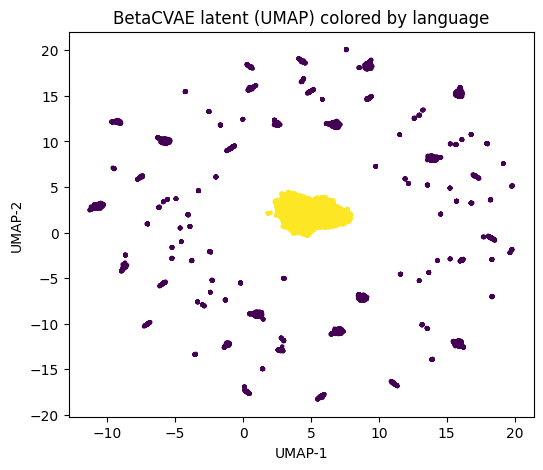

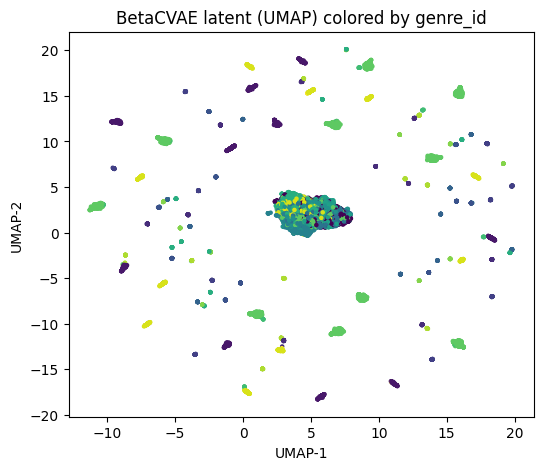

Best algos: agg_ward agg_ward agg_ward
Available keys: dict_keys(['kmeans', 'agg_ward']) dict_keys(['kmeans', 'agg_ward']) dict_keys(['kmeans', 'agg_ward'])


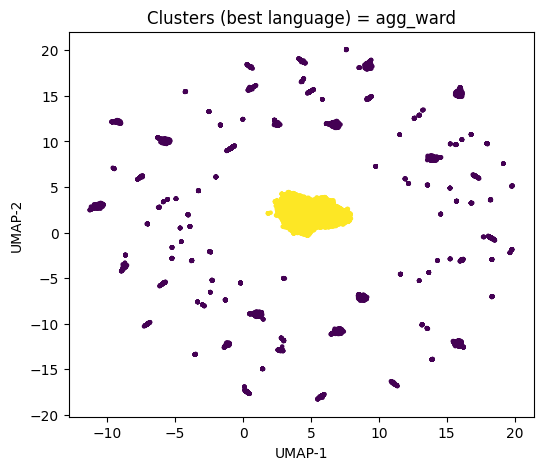

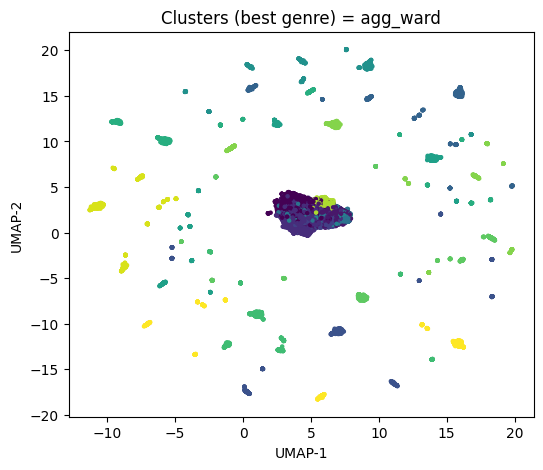

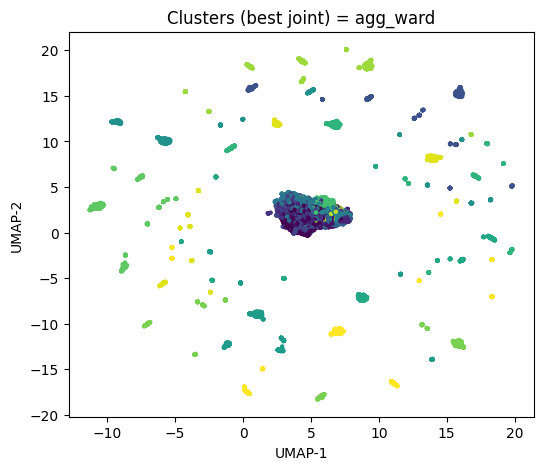

In [81]:
Z2 = umap.UMAP(n_components=2, random_state=SEED).fit_transform(Zs)

def scatter_colored(c, title):
    plt.figure(figsize=(6,5))
    plt.scatter(Z2[:,0], Z2[:,1], c=c, s=5)
    plt.title(title)
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.show()

scatter_colored(y_lang, "BetaCVAE latent (UMAP) colored by language")
scatter_colored(y_gen,  "BetaCVAE latent (UMAP) colored by genre_id")

# Correctly extract algorithm keys from the "target" strings
best_lang_algo  = df_hard_main[df_hard_main["target"].str.startswith("language_")].iloc[0]["target"].replace("language_", "", 1)
best_gen_algo   = df_hard_main[df_hard_main["target"].str.startswith("genre_")].iloc[0]["target"].replace("genre_", "", 1)
best_joint_algo = df_hard_main[df_hard_main["target"].str.startswith("joint_")].iloc[0]["target"].replace("joint_", "", 1)

print("Best algos:", best_lang_algo, best_gen_algo, best_joint_algo)
print("Available keys:", labels_lang.keys(), labels_genre.keys(), labels_joint.keys())

lab_lang_best  = labels_lang[best_lang_algo]
lab_gen_best   = labels_genre[best_gen_algo]
lab_joint_best = labels_joint[best_joint_algo]

scatter_colored(lab_lang_best,  f"Clusters (best language) = {best_lang_algo}")
scatter_colored(lab_gen_best,   f"Clusters (best genre) = {best_gen_algo}")
scatter_colored(lab_joint_best, f"Clusters (best joint) = {best_joint_algo}")

In [82]:
def crosstab_norm(a, b):
    tab = pd.crosstab(a, b)
    tab_norm = tab.div(tab.sum(axis=0), axis=1)  # per-cluster distribution
    return tab, tab_norm

tabL, tabL_norm = crosstab_norm(df["language"], lab_joint_best)
tabG, tabG_norm = crosstab_norm(df["genre_norm"], lab_joint_best)

print("Language x cluster (counts):")
display(tabL)

print("Language x cluster (per-cluster proportions):")
display(tabL_norm)

print("Genre x cluster (counts):")
display(tabG)

print("Genre x cluster (per-cluster proportions):")
display(tabG_norm)

tabL.to_csv(OUT_DIR / "cluster_vs_language_counts.csv")
tabG.to_csv(OUT_DIR / "cluster_vs_genre_counts.csv")

Language x cluster (counts):


col_0,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
language,,,,,,,,,,,,,,,,,,,,,
bengali,2725,885,1184,1579,2539,0,538,520,1600,2024,...,0,0,0,923,0,0,0,483,0,0
english,0,0,0,0,0,1500,0,0,0,0,...,1500,1500,1500,0,1500,1500,1500,0,1500,1500


Language x cluster (per-cluster proportions):


col_0,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
language,,,,,,,,,,,,,,,,,,,,,
bengali,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
english,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


Genre x cluster (counts):


col_0,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
genre_norm,,,,,,,,,,,,,,,,,,,,,
adhunik,155,140,315,61,215,0,154,213,107,414,...,0,0,0,92,0,0,0,154,0,0
alternative,0,0,0,0,0,381,0,0,0,0,...,381,381,381,0,381,381,381,0,381,381
bolero,0,0,0,0,0,2,0,0,0,0,...,2,2,2,0,2,2,2,0,2,2
chanson française,0,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,0,1,1
country,0,0,0,0,0,39,0,0,0,0,...,39,39,39,0,39,39,39,0,39,39
dance,0,0,0,0,0,63,0,0,0,0,...,63,63,63,0,63,63,63,0,63,63
electro,0,0,0,0,0,33,0,0,0,0,...,33,33,33,0,33,33,33,0,33,33
films/jeux vidéo,0,0,0,0,0,21,0,0,0,0,...,21,21,21,0,21,21,21,0,21,21
folk,212,205,203,152,293,3,115,100,56,657,...,3,3,3,98,3,3,3,89,3,3


Genre x cluster (per-cluster proportions):


col_0,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
genre_norm,,,,,,,,,,,,,,,,,,,,,
adhunik,0.056881,0.158192,0.266047,0.038632,0.084679,0.000000,0.286245,0.409615,0.066875,0.204545,...,0.000000,0.000000,0.000000,0.099675,0.000000,0.000000,0.000000,0.318841,0.000000,0.000000
alternative,0.000000,0.000000,0.000000,0.000000,0.000000,0.254000,0.000000,0.000000,0.000000,0.000000,...,0.254000,0.254000,0.254000,0.000000,0.254000,0.254000,0.254000,0.000000,0.254000,0.254000
bolero,0.000000,0.000000,0.000000,0.000000,0.000000,0.001333,0.000000,0.000000,0.000000,0.000000,...,0.001333,0.001333,0.001333,0.000000,0.001333,0.001333,0.001333,0.000000,0.001333,0.001333
chanson française,0.000000,0.000000,0.000000,0.000000,0.000000,0.000667,0.000000,0.000000,0.000000,0.000000,...,0.000667,0.000667,0.000667,0.000000,0.000667,0.000667,0.000667,0.000000,0.000667,0.000667
country,0.000000,0.000000,0.000000,0.000000,0.000000,0.026000,0.000000,0.000000,0.000000,0.000000,...,0.026000,0.026000,0.026000,0.000000,0.026000,0.026000,0.026000,0.000000,0.026000,0.026000
dance,0.000000,0.000000,0.000000,0.000000,0.000000,0.042000,0.000000,0.000000,0.000000,0.000000,...,0.042000,0.042000,0.042000,0.000000,0.042000,0.042000,0.042000,0.000000,0.042000,0.042000
electro,0.000000,0.000000,0.000000,0.000000,0.000000,0.022000,0.000000,0.000000,0.000000,0.000000,...,0.022000,0.022000,0.022000,0.000000,0.022000,0.022000,0.022000,0.000000,0.022000,0.022000
films/jeux vidéo,0.000000,0.000000,0.000000,0.000000,0.000000,0.014000,0.000000,0.000000,0.000000,0.000000,...,0.014000,0.014000,0.014000,0.000000,0.014000,0.014000,0.014000,0.000000,0.014000,0.014000
folk,0.077798,0.231638,0.171453,0.096263,0.115400,0.002000,0.213755,0.192308,0.035000,0.324605,...,0.002000,0.002000,0.002000,0.106176,0.002000,0.002000,0.002000,0.184265,0.002000,0.002000


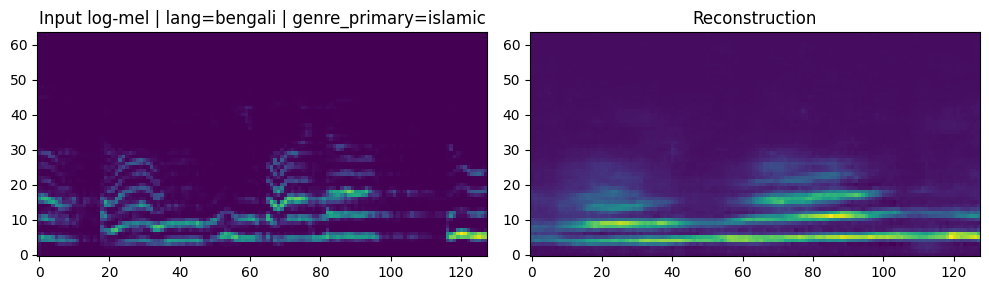

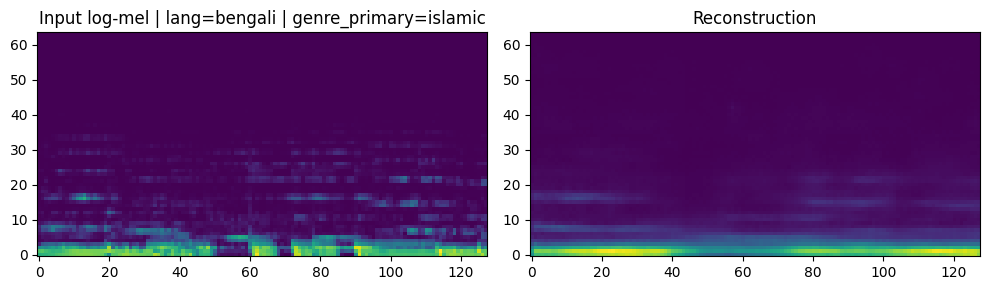

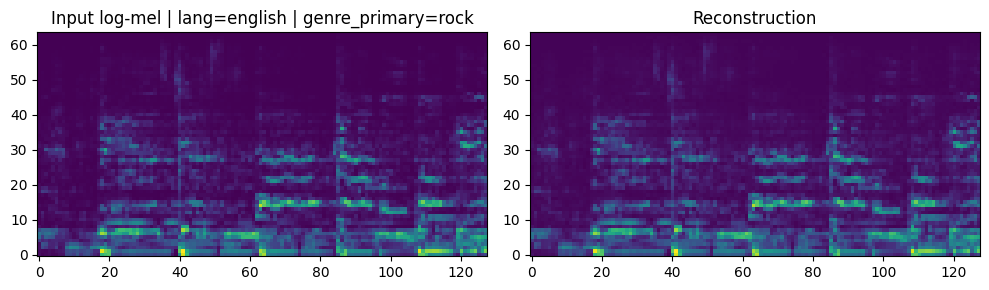

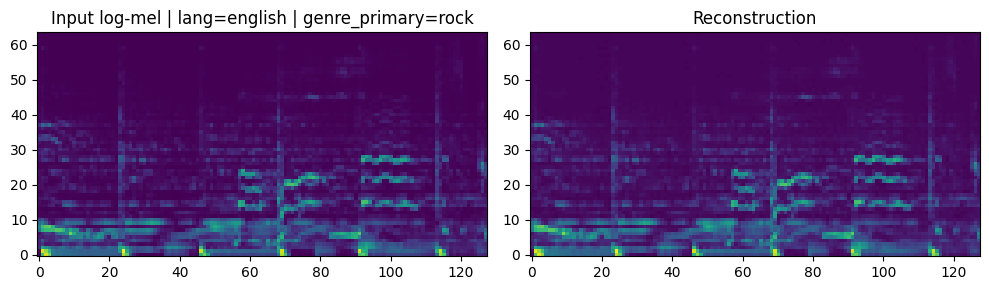

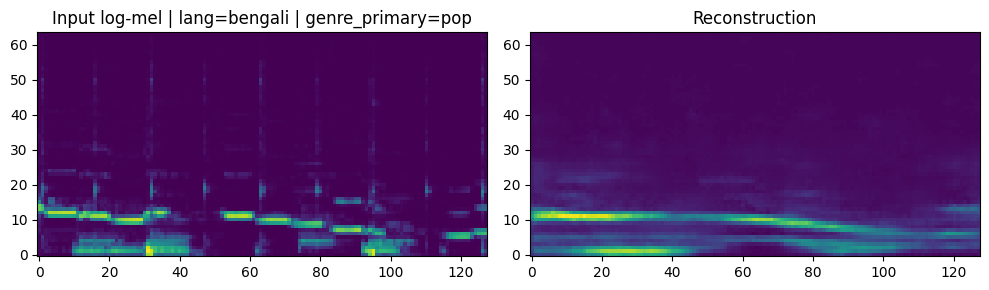

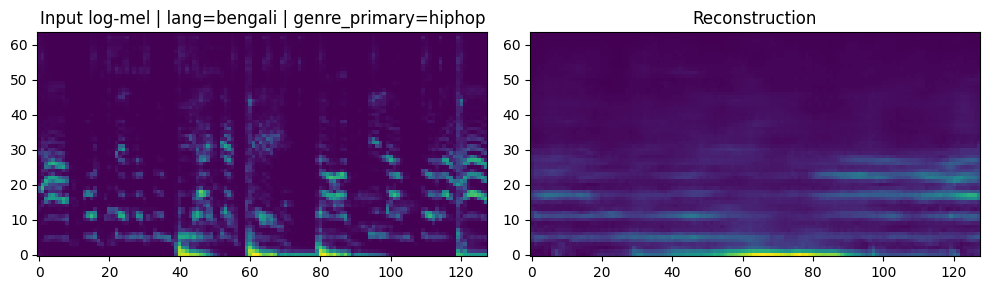

Lyrics recon MSE (samples): [4.1241827e-05 1.3869729e-05 1.6803900e-04 3.7327854e-04 2.6754595e-04
 2.4912527e-04]
Mean lyrics recon MSE: 0.00018551672
True tags per sample: [1. 1. 1. 1. 1. 1.]
Pred tags per sample: [1 0 1 2 0 0]


In [83]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

n_show = 6
pick = np.random.choice(len(df), size=n_show, replace=False)

# Use the SAME inputs your encoder expects in Hard v2:
xa = X_audio[pick].astype(np.float32)      # (n,64,128,1)
xl = X_lyr[pick].astype(np.float32)        # (n,LYR_DIM)
gm = G_multi[pick].astype(np.float32)      # (n,num_tags_model)  <-- multi-hot tags

# Convert all to tensors (avoid tensor/numpy mixing issues)
xa_t = tf.convert_to_tensor(xa)
xl_t = tf.convert_to_tensor(xl)
gm_t = tf.convert_to_tensor(gm)

# Encode
z_mean, z_logv, z = encoder([xa_t, xl_t, gm_t], training=False)

# Decode (decoder expects ONLY z now)
xa_hat, xl_hat, gm_hat = decoder(z_mean, training=False)

xa_hat = xa_hat.numpy()
xl_hat = xl_hat.numpy()
gm_hat = gm_hat.numpy()

# Plot audio spectrogram reconstructions
for i in range(n_show):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.imshow(xa[i,:,:,0], aspect="auto", origin="lower")
    plt.title(f"Input log-mel | lang={df.loc[pick[i],'language']} | genre_primary={df.loc[pick[i],'genre_primary']}")
    plt.subplot(1,2,2)
    plt.imshow(xa_hat[i,:,:,0], aspect="auto", origin="lower")
    plt.title("Reconstruction")
    plt.tight_layout()
    plt.show()

# Lyrics recon error (vector space)
mse_lyr = np.mean((xl - xl_hat)**2, axis=1)
print("Lyrics recon MSE (samples):", mse_lyr)
print("Mean lyrics recon MSE:", mse_lyr.mean())

# Genre multi-label recon (how many tags are predicted)
pred_tags_per_sample = (gm_hat > 0.5).sum(axis=1)
true_tags_per_sample = gm.sum(axis=1)
print("True tags per sample:", true_tags_per_sample)
print("Pred tags per sample:", pred_tags_per_sample)

In [84]:
A_flat = X_a_all.reshape(len(df), -1).astype(np.float32)
F = np.concatenate([A_flat, X_l_all, G_all], axis=1)

Fs = StandardScaler().fit_transform(F)

pca_dim = 64
Fp = PCA(n_components=pca_dim, random_state=SEED).fit_transform(Fs)

# cluster with same k as joint
lab_pca = KMeans(n_clusters=k_joint, random_state=SEED, n_init="auto").fit_predict(Fp)

row_pca_joint = eval_clustering(Fp, lab_pca, y_joint, f"PCA({pca_dim})+KMeans", "joint_kmeans")
row_pca_joint

{'repr': 'PCA(64)+KMeans',
 'target': 'joint_kmeans',
 'k': 21,
 'silhouette': 0.5025830268859863,
 'ari': 0.09840809631996429,
 'nmi': 0.31202132407833577,
 'purity': 0.3712666666666667}

In [85]:
BOTTLENECK = 32

inp = keras.Input(shape=(F.shape[1],))
h = layers.Dense(512, activation="relu")(inp)
h = layers.Dense(256, activation="relu")(h)
z_ae = layers.Dense(BOTTLENECK, activation=None, name="z")(h)
h2 = layers.Dense(256, activation="relu")(z_ae)
h2 = layers.Dense(512, activation="relu")(h2)
out = layers.Dense(F.shape[1], activation=None)(h2)

ae = keras.Model(inp, out)
enc_ae = keras.Model(inp, z_ae)

ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
ae.fit(Fs, Fs, epochs=15, batch_size=256, validation_split=0.1,
       callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)])

Zae = enc_ae.predict(Fs, batch_size=256, verbose=0)
Zae_s = StandardScaler().fit_transform(Zae)

lab_ae = KMeans(n_clusters=k_joint, random_state=SEED, n_init="auto").fit_predict(Zae_s)
row_ae_joint = eval_clustering(Zae_s, lab_ae, y_joint, f"Autoencoder(z={BOTTLENECK})+KMeans", "joint_kmeans")
row_ae_joint

Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.7533 - val_loss: 0.6156
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5690 - val_loss: 0.5847
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5427 - val_loss: 0.5710
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5262 - val_loss: 0.5682
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5153 - val_loss: 0.5649
Epoch 6/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5078 - val_loss: 0.5625
Epoch 7/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5004 - val_loss: 0.5576
Epoch 8/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4944 - val_loss: 0.5575
Epoch 9/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4896 - val_loss: 0.5582
Epoch 10/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4878 - val_loss: 0.5591
Epoch 11/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4848 - val_loss: 0.5603


{'repr': 'Autoencoder(z=32)+KMeans',
 'target': 'joint_kmeans',
 'k': 21,
 'silhouette': 0.4440058469772339,
 'ari': 0.09718592580268687,
 'nmi': 0.30297293993942925,
 'purity': 0.3668}

In [86]:
def wav_to_mfcc_stats(path, sr=SR, n_mfcc=20):
    y, _ = librosa.load(path, sr=sr, mono=True)
    target_len = int(sr * 3.0)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mu = mfcc.mean(axis=1)
    sd = mfcc.std(axis=1)
    return np.concatenate([mu, sd], axis=0).astype(np.float32)

X_mfcc = np.zeros((len(df), 40), dtype=np.float32)
for i, p in enumerate(tqdm(df["clip_path"].tolist(), desc="MFCC stats")):
    X_mfcc[i] = wav_to_mfcc_stats(p)

Xm = StandardScaler().fit_transform(X_mfcc)
lab_mfcc = KMeans(n_clusters=k_joint, random_state=SEED, n_init="auto").fit_predict(Xm)

row_mfcc_joint = eval_clustering(Xm, lab_mfcc, y_joint, "MFCC(mean+std)+KMeans", "joint_kmeans")
row_mfcc_joint

MFCC stats: 100%|██████████| 30000/30000 [06:50<00:00, 73.12it/s]


{'repr': 'MFCC(mean+std)+KMeans',
 'target': 'joint_kmeans',
 'k': 21,
 'silhouette': 0.3414577543735504,
 'ari': 0.15622612223327287,
 'nmi': 0.35451903638729004,
 'purity': 0.4361333333333333}

In [87]:
rows_final = []
# best BetaCVAE joint row already in df_hard_main; take best joint for reporting
best_joint_row = df_hard_main[df_hard_main["target"].str.startswith("joint_")].iloc[0].to_dict()
best_joint_row["method"] = "BetaCVAE (best joint)"
rows_final.append(best_joint_row)

# add baselines
r = row_pca_joint.copy();  r["method"] = "PCA+KMeans"; rows_final.append(r)
r = row_ae_joint.copy();   r["method"] = "Autoencoder+KMeans"; rows_final.append(r)
r = row_mfcc_joint.copy(); r["method"] = "MFCC+KMeans"; rows_final.append(r)

df_compare = pd.DataFrame(rows_final)[
    ["method","repr","target","k","silhouette","nmi","ari","purity"]
].sort_values("ari", ascending=False).reset_index(drop=True)

df_compare.to_csv(OUT_DIR / "hard_final_comparison.csv", index=False)
df_compare

,method,repr,target,k,silhouette,nmi,ari,purity
0,MFCC+KMeans,MFCC(mean+std)+KMeans,joint_kmeans,21,0.341458,0.354519,0.156226,0.436133
1,BetaCVAE (best joint),BetaVAE_z(32),joint_agg_ward,21,0.449759,0.307559,0.099999,0.384967
2,PCA+KMeans,PCA(64)+KMeans,joint_kmeans,21,0.502583,0.312021,0.098408,0.371267
3,Autoencoder+KMeans,Autoencoder(z=32)+KMeans,joint_kmeans,21,0.444006,0.302973,0.097186,0.366800


In [88]:
out = df.copy()
out["z0"] = Z[:,0]
out["z1"] = Z[:,1]
out["cluster_joint_best"] = lab_joint_best
out["cluster_lang_best"] = lab_lang_best
out["cluster_gen_best"] = lab_gen_best

out_path = OUT_DIR / "hard_outputs_per_clip.csv"
out.to_csv(out_path, index=False)
print("Saved ->", out_path)
print("All outputs in:", OUT_DIR)

Saved -> /content/drive/MyDrive/hard_task_outputs/hard_outputs_per_clip.csv
All outputs in: /content/drive/MyDrive/hard_task_outputs
